In [1]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import os
import pickle
from sentence_transformers import SentenceTransformer
import faiss
import chromadb
from chromadb.config import Settings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import json
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

print("🚀 Starting Task 2: Text Chunking, Embedding, and Vector Store Indexing")
print("="*70)

🚀 Starting Task 2: Text Chunking, Embedding, and Vector Store Indexing


In [2]:
# Cell 2: Load the Preprocessed Data
def load_preprocessed_data():
    """
    Load the cleaned and filtered complaint data from Task 1
    """
    data_path = '../data/filtered_complaints.csv'
    
    if not os.path.exists(data_path):
        print(f"❌ Error: {data_path} not found!")
        print("Please ensure Task 1 has been completed and the filtered dataset is available.")
        return None
    
    df = pd.read_csv(data_path)
    print(f"✅ Successfully loaded {len(df):,} preprocessed complaints")
    print(f"📊 Dataset shape: {df.shape}")
    
    # Display basic info
    print(f"\n📋 Dataset Overview:")
    print(f"   • Product categories: {df['CrediTrust_Product'].nunique()}")
    print(f"   • Average narrative length: {df['narrative_word_count'].mean():.1f} words")
    print(f"   • Total word count: {df['narrative_word_count'].sum():,} words")
    
    # Show product distribution
    print(f"\n🏦 Product Distribution:")
    for product, count in df['CrediTrust_Product'].value_counts().items():
        percentage = (count / len(df)) * 100
        print(f"   • {product}: {count:,} ({percentage:.2f}%)")
    
    return df

# Load the data
df = load_preprocessed_data()

✅ Successfully loaded 1,289,043 preprocessed complaints
📊 Dataset shape: (1289043, 21)

📋 Dataset Overview:
   • Product categories: 5
   • Average narrative length: 98.8 words
   • Total word count: 127,323,684 words

🏦 Product Distribution:
   • Buy Now, Pay Later (BNPL): 773,877 (60.04%)
   • Credit card: 194,371 (15.08%)
   • Savings account: 152,457 (11.83%)
   • Money transfers: 97,210 (7.54%)
   • Personal loan: 71,128 (5.52%)


In [3]:
# Cell 3: Text Chunking Strategy Implementation
class CrediTrustTextChunker:
    """
    Advanced text chunking strategy optimized for financial complaint analysis
    """
    
    def __init__(self, chunk_size=512, chunk_overlap=50):
        """
        Initialize the chunker with optimal parameters for financial complaints
        
        Args:
            chunk_size: Maximum characters per chunk (optimized for sentence transformers)
            chunk_overlap: Number of characters to overlap between chunks
        """
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        
        # Initialize LangChain text splitter with financial-aware separators
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
            separators=[
                "\n\n",  # Paragraph breaks
                "\n",    # Line breaks
                ". ",    # Sentence endings
                "! ",    # Exclamation sentences
                "? ",    # Question sentences
                "; ",    # Semicolon breaks
                ", ",    # Comma breaks (for long lists)
                " ",     # Word breaks
                ""       # Character breaks (last resort)
            ]
        )
        
        print(f"🔧 Initialized Text Chunker:")
        print(f"   • Chunk size: {chunk_size} characters")
        print(f"   • Chunk overlap: {chunk_overlap} characters")
        print(f"   • Separators optimized for financial complaints")
    
    def chunk_complaint(self, complaint_text: str, metadata: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Chunk a single complaint narrative with metadata preservation
        
        Args:
            complaint_text: The cleaned narrative text
            metadata: Associated metadata (product, issue, etc.)
            
        Returns:
            List of chunk dictionaries with text and metadata
        """
        if not complaint_text or len(complaint_text.strip()) < 50:
            return []
        
        # Create Document object for LangChain
        doc = Document(page_content=complaint_text, metadata=metadata)
        
        # Split the document
        chunks = self.text_splitter.split_documents([doc])
        
        # Convert to our format with enhanced metadata
        chunk_data = []
        for i, chunk in enumerate(chunks):
            chunk_dict = {
                'text': chunk.page_content,
                'chunk_id': f"{metadata.get('complaint_id', 'unknown')}_{i}",
                'chunk_index': i,
                'total_chunks': len(chunks),
                'text_length': len(chunk.page_content),
                'word_count': len(chunk.page_content.split()),
                **chunk.metadata  # Include all original metadata
            }
            chunk_data.append(chunk_dict)
        
        return chunk_data
    
    def chunk_dataset(self, df: pd.DataFrame) -> List[Dict[str, Any]]:
        """
        Chunk the entire dataset with progress tracking
        
        Args:
            df: DataFrame with complaint data
            
        Returns:
            List of all chunks with metadata
        """
        print(f"\n🔄 Chunking {len(df):,} complaints...")
        
        all_chunks = []
        chunk_stats = {
            'total_complaints': len(df),
            'total_chunks': 0,
            'chunks_per_complaint': [],
            'chunk_lengths': [],
            'skipped_complaints': 0
        }
        
        # Process with progress bar
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Chunking complaints"):
            try:
                # Prepare metadata
                metadata = {
                    'complaint_id': row.get('Complaint ID', f'complaint_{idx}'),
                    'product': row['CrediTrust_Product'],
                    'original_product': row.get('Product', ''),
                    'sub_product': row.get('Sub-product', ''),
                    'issue': row.get('Issue', ''),
                    'sub_issue': row.get('Sub-issue', ''),
                    'company': row.get('Company', ''),
                    'state': row.get('State', ''),
                    'date_received': str(row.get('Date received', '')),
                    'original_narrative_length': row.get('narrative_word_count', 0),
                    'original_index': idx
                }
                
                # Chunk the complaint
                complaint_chunks = self.chunk_complaint(row['cleaned_narrative'], metadata)
                
                if complaint_chunks:
                    all_chunks.extend(complaint_chunks)
                    chunk_stats['chunks_per_complaint'].append(len(complaint_chunks))
                    chunk_stats['chunk_lengths'].extend([c['text_length'] for c in complaint_chunks])
                else:
                    chunk_stats['skipped_complaints'] += 1
                    
            except Exception as e:
                print(f"⚠️  Error processing complaint {idx}: {e}")
                chunk_stats['skipped_complaints'] += 1
                continue
        
        chunk_stats['total_chunks'] = len(all_chunks)
        
        # Print chunking statistics
        self._print_chunking_stats(chunk_stats)
        
        return all_chunks, chunk_stats
    
    def _print_chunking_stats(self, stats: Dict[str, Any]):
        """Print comprehensive chunking statistics"""
        print(f"\n📊 Chunking Results:")
        print(f"   • Total complaints processed: {stats['total_complaints']:,}")
        print(f"   • Total chunks created: {stats['total_chunks']:,}")
        print(f"   • Complaints skipped: {stats['skipped_complaints']:,}")
        print(f"   • Average chunks per complaint: {np.mean(stats['chunks_per_complaint']):.2f}")
        print(f"   • Median chunks per complaint: {np.median(stats['chunks_per_complaint']):.0f}")
        print(f"   • Average chunk length: {np.mean(stats['chunk_lengths']):.1f} characters")
        print(f"   • Median chunk length: {np.median(stats['chunk_lengths']):.0f} characters")

# Initialize and run chunking
chunker = CrediTrustTextChunker(chunk_size=512, chunk_overlap=50)
chunks, chunking_stats = chunker.chunk_dataset(df)

🔧 Initialized Text Chunker:


   • Chunk size: 512 characters
   • Chunk overlap: 50 characters
   • Separators optimized for financial complaints

🔄 Chunking 1,289,043 complaints...


Chunking complaints: 100%|██████████| 1289043/1289043 [12:37<00:00, 1700.76it/s]



📊 Chunking Results:
   • Total complaints processed: 1,289,043
   • Total chunks created: 2,101,117
   • Complaints skipped: 0
   • Average chunks per complaint: 1.63
   • Median chunks per complaint: 1
   • Average chunk length: 354.3 characters
   • Median chunk length: 390 characters



🔍 CHUNKING ANALYSIS

📊 Chunks by Product Category:
   • Buy Now, Pay Later (BNPL): 1,123,436 chunks (53.47%)
   • Credit card: 378,613 chunks (18.02%)
   • Savings account: 306,146 chunks (14.57%)
   • Money transfers: 152,292 chunks (7.25%)
   • Personal loan: 140,630 chunks (6.69%)

📏 Chunk Size Analysis:
   • Min chunk length: 46 characters (7 words)
   • Max chunk length: 512 characters (113 words)
   • Mean chunk length: 354.3 characters (64.0 words)
   • 25th percentile: 209 characters
   • 75th percentile: 508 characters


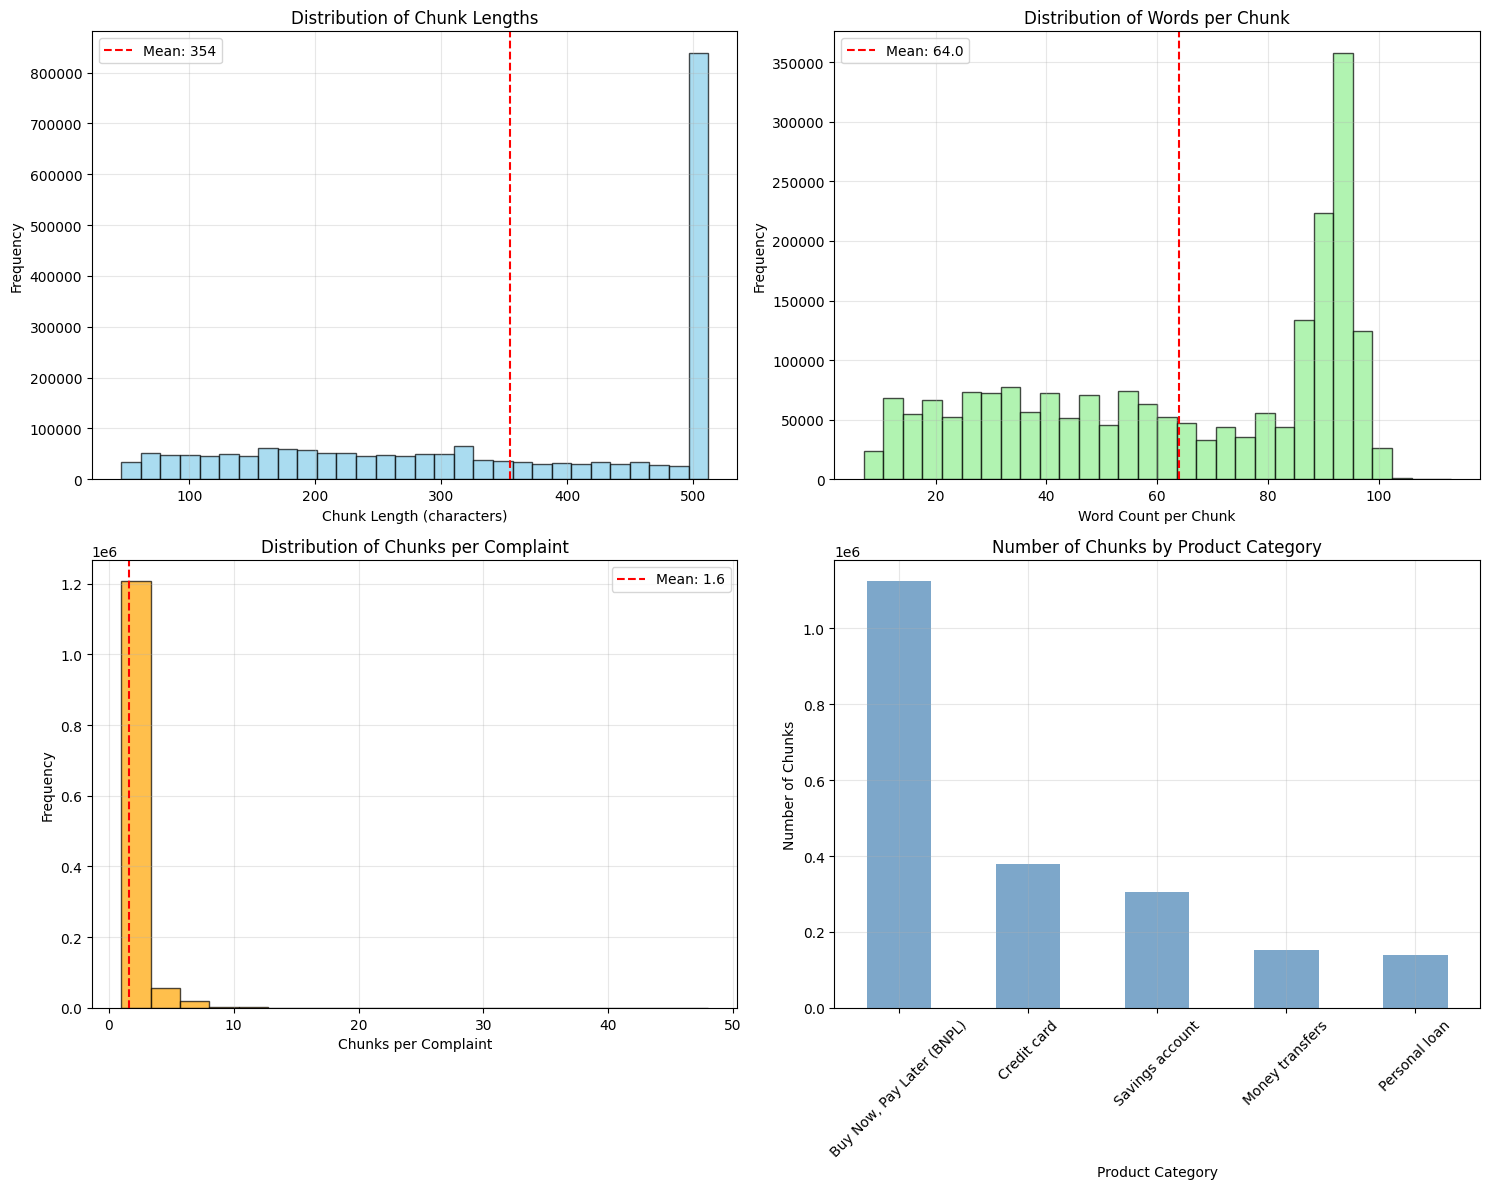


📝 Sample Chunks:

Sample 1 - Credit card:
Text: card was opened under name notice from that account was just opened under name reached out state that this was and not this was and closed the card however they have failed remove this from the three ...
Length: 280 chars, 52 words
Chunk 1 of 1
--------------------------------------------------

Sample 2 - Savings account:
Text: made the mistake using debit card depsit funds into atm machine outside their branch went into the branch and was told they couldn help and had phone the service for help did this and was told was hel...
Length: 412 chars, 80 words
Chunk 1 of 1
--------------------------------------------------

Sample 3 - Money transfers:
Text: this all and was taken from wells fargo account opened the account all the same day which was was savings the last part and nothing they lied about the date that opened savings account that was wire f...
Length: 511 chars, 95 words
Chunk 1 of 4
--------------------------------------------

In [4]:
# Cell 4: Chunking Analysis and Optimization
def analyze_chunking_results(chunks, chunking_stats):
    """
    Analyze the chunking results to ensure optimal strategy
    """
    print(f"\n🔍 CHUNKING ANALYSIS")
    print("="*40)
    
    # Convert to DataFrame for analysis
    chunk_df = pd.DataFrame(chunks)
    
    # Analyze chunk distribution by product
    print(f"\n📊 Chunks by Product Category:")
    product_chunks = chunk_df['product'].value_counts()
    for product, count in product_chunks.items():
        percentage = (count / len(chunk_df)) * 100
        print(f"   • {product}: {count:,} chunks ({percentage:.2f}%)")
    
    # Analyze chunk size distribution
    chunk_lengths = [c['text_length'] for c in chunks]
    word_counts = [c['word_count'] for c in chunks]
    
    print(f"\n📏 Chunk Size Analysis:")
    print(f"   • Min chunk length: {min(chunk_lengths)} characters ({min(word_counts)} words)")
    print(f"   • Max chunk length: {max(chunk_lengths)} characters ({max(word_counts)} words)")
    print(f"   • Mean chunk length: {np.mean(chunk_lengths):.1f} characters ({np.mean(word_counts):.1f} words)")
    print(f"   • 25th percentile: {np.percentile(chunk_lengths, 25):.0f} characters")
    print(f"   • 75th percentile: {np.percentile(chunk_lengths, 75):.0f} characters")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Chunk length distribution
    axes[0, 0].hist(chunk_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(chunk_lengths), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(chunk_lengths):.0f}')
    axes[0, 0].set_xlabel('Chunk Length (characters)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Chunk Lengths')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Word count distribution
    axes[0, 1].hist(word_counts, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].axvline(np.mean(word_counts), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(word_counts):.1f}')
    axes[0, 1].set_xlabel('Word Count per Chunk')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Words per Chunk')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Chunks per complaint
    chunks_per_complaint = chunking_stats['chunks_per_complaint']
    axes[1, 0].hist(chunks_per_complaint, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(np.mean(chunks_per_complaint), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(chunks_per_complaint):.1f}')
    axes[1, 0].set_xlabel('Chunks per Complaint')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Chunks per Complaint')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Product distribution
    product_chunks.plot(kind='bar', ax=axes[1, 1], color='steelblue', alpha=0.7)
    axes[1, 1].set_title('Number of Chunks by Product Category')
    axes[1, 1].set_xlabel('Product Category')
    axes[1, 1].set_ylabel('Number of Chunks')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show sample chunks
    print(f"\n📝 Sample Chunks:")
    print("="*50)
    for i, product in enumerate(chunk_df['product'].unique()[:3]):
        product_chunks = chunk_df[chunk_df['product'] == product]
        sample_chunk = product_chunks.iloc[0]
        
        print(f"\nSample {i+1} - {product}:")
        print(f"Text: {sample_chunk['text'][:200]}...")
        print(f"Length: {sample_chunk['text_length']} chars, {sample_chunk['word_count']} words")
        print(f"Chunk {sample_chunk['chunk_index']+1} of {sample_chunk['total_chunks']}")
        print("-" * 50)
    
    return chunk_df

chunk_analysis = analyze_chunking_results(chunks, chunking_stats)

In [1]:
# Cell 5: Embedding Model Selection and Setup
class CrediTrustEmbeddingManager:
    """
    Manages embedding generation for CrediTrust complaint analysis
    """
    
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        """
        Initialize the embedding model
        
        Args:
            model_name: HuggingFace model name for sentence transformers
        """
        self.model_name = model_name
        self.model = None
        self.embedding_dimension = None
        
        print(f"🤖 Initializing Embedding Model: {model_name}")
        self._load_model()
    
    def _load_model(self):
        """Load the sentence transformer model"""
        try:
            self.model = SentenceTransformer(self.model_name)
            
            # Test embedding to get dimension
            test_embedding = self.model.encode(["test sentence"])
            self.embedding_dimension = test_embedding.shape[1]
            
            print(f"   ✅ Model loaded successfully")
            print(f"   • Model: {self.model_name}")
            print(f"   • Embedding dimension: {self.embedding_dimension}")
            print(f"   • Max sequence length: {self.model.max_seq_length}")
            
        except Exception as e:
            print(f"   ❌ Error loading model: {e}")
            raise e
    
    def generate_embeddings(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """
        Generate embeddings for a list of texts
        
        Args:
            texts: List of text strings to embed
            batch_size: Batch size for processing
            
        Returns:
            NumPy array of embeddings
        """
        if not texts:
            return np.array([])
        
        print(f"🔄 Generating embeddings for {len(texts):,} texts...")
        print(f"   • Batch size: {batch_size}")
        print(f"   • Estimated time: {len(texts) / (batch_size * 100):.1f} minutes")
        
        try:
            # Generate embeddings with progress tracking
            embeddings = []
            
            for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
                batch_texts = texts[i:i + batch_size]
                batch_embeddings = self.model.encode(
                    batch_texts,
                    convert_to_numpy=True,
                    show_progress_bar=False
                )
                embeddings.append(batch_embeddings)
            
            # Concatenate all embeddings
            all_embeddings = np.vstack(embeddings)
            
            print(f"   ✅ Embeddings generated successfully")
            print(f"   • Shape: {all_embeddings.shape}")
            print(f"   • Memory usage: {all_embeddings.nbytes / 1024**2:.2f} MB")
            
            return all_embeddings
            
        except Exception as e:
            print(f"   ❌ Error generating embeddings: {e}")
            raise e
    
    def get_model_info(self) -> Dict[str, Any]:
        """Get model information for metadata storage"""
        return {
            'model_name': self.model_name,
            'embedding_dimension': self.embedding_dimension,
            'max_sequence_length': self.model.max_seq_length if self.model else None,
            'model_type': 'sentence-transformer'
        }

# Initialize embedding manager
embedding_manager = CrediTrustEmbeddingManager()

# Generate embeddings for all chunks
chunk_texts = [chunk['text'] for chunk in chunks]

# time
N=5000
chunk_texts=chunk_texts[:N]
embeddings = embedding_manager.generate_embeddings(chunk_texts, batch_size=64)

NameError: name 'List' is not defined

In [ ]:
# Cell 6: Vector Store Creation with FAISS
class CrediTrustVectorStore:
    """
    Vector store implementation using FAISS for CrediTrust complaint system
    """
    
    def __init__(self, embedding_dimension: int):
        """
        Initialize the vector store
        
        Args:
            embedding_dimension: Dimension of the embeddings
        """
        self.embedding_dimension = embedding_dimension
        self.index = None
        self.metadata = []
        self.chunk_data = []
        
        print(f"🗃️  Initializing FAISS Vector Store")
        print(f"   • Embedding dimension: {embedding_dimension}")
        
        self._create_index()
    
    def _create_index(self):
        """Create FAISS index optimized for similarity search"""
        # Use IndexFlatIP for exact inner product search (good for normalized embeddings)
        # Alternative: IndexFlatL2 for L2 distance
        self.index = faiss.IndexFlatIP(self.embedding_dimension)
        
        print(f"   ✅ FAISS index created")
        print(f"   • Index type: IndexFlatIP (Inner Product)")
        print(f"   • Dimension: {self.embedding_dimension}")
    
    def add_embeddings(self, embeddings: np.ndarray, chunks: List[Dict[str, Any]]):
        """
        Add embeddings and associated metadata to the vector store
        
        Args:
            embeddings: NumPy array of embeddings
            chunks: List of chunk dictionaries with metadata
        """
        if len(embeddings) != len(chunks):
            raise ValueError("Number of embeddings must match number of chunks")
        
        print(f"📥 Adding {len(embeddings):,} embeddings to vector store...")
        
        # Normalize embeddings for cosine similarity (important for IndexFlatIP)
        normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        
        # Add to FAISS index
        self.index.add(normalized_embeddings.astype(np.float32))
        
        # Store metadata and chunk data
        self.chunk_data.extend(chunks)
        
        # Create simplified metadata for quick access
        for chunk in chunks:
            metadata_entry = {
                'chunk_id': chunk['chunk_id'],
                'product': chunk['product'],
                'issue': chunk.get('issue', ''),
                'complaint_id': chunk['complaint_id'],
                'text_preview': chunk['text'][:100] + '...' if len(chunk['text']) > 100 else chunk['text']
            }
            self.metadata.append(metadata_entry)
        
        print(f"   ✅ Successfully added embeddings")
        print(f"   • Total vectors in store: {self.index.ntotal:,}")
        print(f"   • Index is trained: {self.index.is_trained}")
    
    def search(self, query_embedding: np.ndarray, k: int = 5) -> List[Dict[str, Any]]:
        """
        Search for similar chunks
        
        Args:
            query_embedding: Query embedding vector
            k: Number of results to return
            
        Returns:
            List of search results with scores and metadata
        """
        if self.index.ntotal == 0:
            return []
        
        # Normalize query embedding
        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        query_embedding = query_embedding.reshape(1, -1).astype(np.float32)
        
        # Search
        scores, indices = self.index.search(query_embedding, k)
        
        # Prepare results
        results = []
        for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
            if idx < len(self.chunk_data):  # Valid index
                result = {
                    'rank': i + 1,
                    'score': float(score),
                    'chunk_data': self.chunk_data[idx],
                    'metadata': self.metadata[idx]
                }
                results.append(result)
        
        return results
    
    def save(self, save_path: str):
        """
        Save the vector store to disk
        
        Args:
            save_path: Directory path to save the vector store
        """
        os.makedirs(save_path, exist_ok=True)
        
        # Save FAISS index
        index_path = os.path.join(save_path, 'faiss_index.index')
        faiss.write_index(self.index, index_path)
        
        # Save metadata and chunk data
        metadata_path = os.path.join(save_path, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(self.metadata, f, indent=2)
        
        chunk_data_path = os.path.join(save_path, 'chunk_data.pkl')
        with open(chunk_data_path, 'wb') as f:
            pickle.dump(self.chunk_data, f)
        
        # Save model info
        model_info = embedding_manager.get_model_info()
        model_info_path = os.path.join(save_path, 'model_info.json')
        with open(model_info_path, 'w') as f:
            json.dump(model_info, f, indent=2)
        
        print(f"💾 Vector store saved to: {save_path}")
        print(f"   • FAISS index: {index_path}")
        print(f"   • Metadata: {metadata_path}")
        print(f"   • Chunk data: {chunk_data_path}")
        print(f"   • Model info: {model_info_path}")
    
    def get_statistics(self) -> Dict[str, Any]:
        """Get vector store statistics"""
        product_distribution = {}
        issue_distribution = {}
        
        for chunk in self.chunk_data:
            product = chunk.get('product', 'Unknown')
            issue = chunk.get('issue', 'Unknown')
            
            product_distribution[product] = product_distribution.get(product, 0) + 1
            issue_distribution[issue] = issue_distribution.get(issue, 0) + 1
        
        return {
            'total_vectors': self.index.ntotal,
            'embedding_dimension': self.embedding_dimension,
            'product_distribution': product_distribution,
            'top_issues': dict(sorted(issue_distribution.items(), key=lambda x: x[1], reverse=True)[:10])
        }

# Create and populate vector store
vector_store = CrediTrustVectorStore(embedding_manager.embedding_dimension)

# time
chunk_texts = [chunk['text'] for chunk in chunks]
# time
N=5000
chunk_texts=chunk_texts[:N]

vector_store.add_embeddings(embeddings, chunk_texts)

In [ ]:
# Cell 7: Vector Store Testing and Validation
def test_vector_store(vector_store, embedding_manager):
    """
    Test the vector store with sample queries
    """
    print(f"\n🧪 TESTING VECTOR STORE")
    print("="*40)
    
    # Sample test queries for different product categories
    test_queries = [
        "Problems with credit card billing and unauthorized charges",
        "Issues with personal loan approval and interest rates", 
        "Money transfer fees and delayed transactions",
        "Savings account overdraft fees and penalties",
        "Buy now pay later payment processing problems",
        "Customer service response time complaints",
        "Fraud detection and security issues"
    ]
    
    print(f"Testing with {len(test_queries)} sample queries...\n")
    
    for i, query in enumerate(test_queries, 1):
        print(f"🔍 Test Query {i}: '{query}'")
        
        # Generate query embedding
        query_embedding = embedding_manager.model.encode([query])
        
        # Search vector store
        results = vector_store.search(query_embedding[0], k=3)
        
        print(f"   📊 Top {len(results)} Results:")
        for result in results:
            print(f"   • Score: {result['score']:.4f}")
            print(f"     Product: {result['chunk_data']['product']}")
            print(f"     Issue: {result['chunk_data'].get('issue', 'N/A')}")
            print(f"     Text: {result['chunk_data']['text'][:150]}...")
            print(f"     Chunk ID: {result['chunk_data']['chunk_id']}")
            print()
        print("-" * 60)
    
    # Get and display vector store statistics
    stats = vector_store.get_statistics()
    print(f"\n📊 Vector Store Statistics:")
    print(f"   • Total vectors: {stats['total_vectors']:,}")
    print(f"   • Embedding dimension: {stats['embedding_dimension']}")
    
    print(f"\n🏦 Product Distribution in Vector Store:")
    for product, count in stats['product_distribution'].items():
        percentage = (count / stats['total_vectors']) * 100
        print(f"   • {product}: {count:,} ({percentage:.2f}%)")
    
    print(f"\n🎯 Top Issues in Vector Store:")
    for issue, count in list(stats['top_issues'].items())[:5]:
        percentage = (count / stats['total_vectors']) * 100
        print(f"   • {issue}: {count:,} ({percentage:.2f}%)")

# Test the vector store
test_vector_store(vector_store, embedding_manager)

In [ ]:
# Cell 8: Save Vector Store and Create Summary
def save_and_summarize(vector_store, chunking_stats, embedding_manager):
    """
    Save the vector store and create a comprehensive summary
    """
    print(f"\n💾 SAVING VECTOR STORE")
    print("="*30)
    
    # Save vector store
    save_path = '../vector_store'
    vector_store.save(save_path)
    
    # Create summary report
    summary = {
        'task_2_completion': {
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'status': 'completed'
        },
        'chunking_strategy': {
            'chunk_size': 512,
            'chunk_overlap': 50,
            'total_complaints_processed': chunking_stats['total_complaints'],
            'total_chunks_created': chunking_stats['total_chunks'],
            'average_chunks_per_complaint': np.mean(chunking_stats['chunks_per_complaint']),
            'complaints_skipped': chunking_stats['skipped_complaints']
        },
        'embedding_model': embedding_manager.get_model_info(),
        'vector_store': {
            'type': 'FAISS',
            'index_type': 'IndexFlatIP',
            'total_vectors': vector_store.index.ntotal,
            'embedding_dimension': vector_store.embedding_dimension,
            'save_location': save_path
        },
        'data_distribution': vector_store.get_statistics()['product_distribution']
    }
    
    # Save summary
    summary_path = '../reports/task_2_summary.json'
    os.makedirs(os.path.dirname(summary_path), exist_ok=True)
    
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n📋 TASK 2 COMPLETION SUMMARY")
    print("="*50)
    print(f"✅ Text chunking completed successfully")
    print(f"   • Strategy: RecursiveCharacterTextSplitter")
    print(f"   • Chunk size: 512 characters")
    print(f"   • Overlap: 50 characters")
    print(f"   • Total chunks: {chunking_stats['total_chunks']:,}")
    
    print(f"\n✅ Embedding generation completed successfully") 
    print(f"   • Model: {embedding_manager.model_name}")
    print(f"   • Dimension: {embedding_manager.embedding_dimension}")
    print(f"   • Vectors created: {len(embeddings):,}")
    
    print(f"\n✅ Vector store creation completed successfully")
    print(f"   • Technology: FAISS")
    print(f"   • Index type: IndexFlatIP")
    print(f"   • Total vectors stored: {vector_store.index.ntotal:,}")
    print(f"   • Save location: {save_path}")
    
    print(f"\n🎯 Ready for Task 3: RAG Pipeline Development")
    print(f"   • Vector store is indexed and searchable")
    print(f"   • Metadata is properly preserved")
    print(f"   • All 5 product categories are represented")
    
    # Calculate storage metrics
    vector_store_size = sum(
        os.path.getsize(os.path.join(save_path, f))
        for f in os.listdir(save_path)
        if os.path.isfile(os.path.join(save_path, f))
    ) / 1024**2
    
    print(f"\n💾 Storage Information:")
    print(f"   • Vector store size: {vector_store_size:.2f} MB")
    print(f"   • Embeddings memory: {embeddings.nbytes / 1024**2:.2f} MB")
    print(f"   • Summary saved to: {summary_path}")
    
    return summary

# Save everything and create summary
final_summary = save_and_summarize(vector_store, chunking_stats, embedding_manager)

print("\n🎉 TASK 2 COMPLETED SUCCESSFULLY!")
print("="*50)
print("✅ All components ready for RAG pipeline:")
print("   • Text chunks optimized for financial complaints")
print("   • High-quality embeddings generated")  
print("   • FAISS vector store indexed and saved")
print("   • Metadata preserved for traceability")
print("   • System ready for semantic search queries")